# Regression in Python

A tutorial by Christoph Carl Kling, datascience ät c-kling.de

GESIS - Leibniz Institute for the Social Sciences

http://www.c-kling.de

This work is licensed under a Creative Commons Attribution 4.0 International License:
https://creativecommons.org/licenses/by/4.0/

## Preparation and Basics

Here we introduce concepts relevant for hypothesis testing, such as
* The normal distribution class in Python
* Maxmimum-Likelihood-Estimation
* Confidence intervals
* Sampling distributions

### Preparation

We start by telling Python to print plots in the notebook. 
Then we load the required libraries.
Additionally to the libraries for hypothesis testing, we load the sklearn library. This library is useful for machine learning tasks such as predicting variables with linear regression. We will later look at regression in detail.

In [3]:
#Plot directly in the notebook
%matplotlib inline
#Statistics library
from scipy import stats as stats
#Library for plotting
import matplotlib.pyplot as plt
#Basic library for data manipulation
import numpy as np
#Library for linear regression
import sklearn.linear_model as sk_lm
import sklearn as skl
#Basic library for loading and analysing data
import pandas as pd

### Predefined functions

Here we define two functions and their helper functions:
* *significance_reg(regression,X,y)*: prints p-values for regression coefficients
 * regression: an instance of LinearRegression() from sklearn
 * X: input values
 * y: output values

* *forward_selection(X,y)*: returns a subset of X found by forward selection
 * X: input values
 * y: output values

In [4]:
#squared error of a (linear) regression
def squared_error (regression, X, y):
    sqe = 0;
    for i in range(0,len(X)):
        y_hat = regression.predict([X[i]]);
        sq_error = (y[i]-y_hat)**2;
        sqe = sqe + sq_error;    
    return sqe;

#prints names and column contents for a table
def print_table (names,columns):
    df = pd.DataFrame();
    for i in range(0,len(names)):
        df[names[i]]=columns[i];
    print(df.to_string(index=False))

def significance_reg(reg,X,y):

    n = len(y);
    k = len(X[0])
    X = np.array(X);    
    sq_err = squared_error(reg,X,y);  
    
    #degrees of freedom for t-statistics
    df = n-k-1;   
    
    sq_err_by_sqx = sq_err * (np.linalg.inv(np.dot(X.T,X)).diagonal());
    t_bi = reg.coef_ * np.sqrt((n-k-1) /  sq_err_by_sqx );     
    
    #two-sided test
    p_values_bi = (1 - stats.t.cdf(abs(t_bi),df))*2;
    
    #here we print the statistics
    
    #first we define the shown coefficient names
    coef_names = [];
    for i in range(0,k):
        coef_names.append("beta %i"%(i+1));
    
    #now we give the rest of the values to be displayed
    table_values = [coef_names,reg.coef_,p_values_bi,t_bi]
    
    #print table using the function defined before
    print_table(["coefficient","value","p-value", "t-statistic"],table_values);

def mse (regression, X, y):
    mean_sq_err = squared_error(regression, X, y) / len(X);
    return mean_sq_err;

def mcp (mse, regression, X, y):
    P = len(X[0]);
    N = len(X);
    sq_err = squared_error(regression,X, y);
    mcp = (sq_err / mse) - N + 2*P;
    return mcp[0];

#returns the indices of the variables of X which we keep according to forward selection
def forward_selection(X,y):
    reg = sk_lm.LinearRegression();
    reg.fit(X,y);
    #The mean squared error of the full model is an estimator of the
    #variance of the full model
    mse_full = mse(reg,X,y);
    print("\nMean squared error full model:", mse_full,"\n");

    mcps = [];
    X = np.array(X);
    
    #number of input variables
    num_variables = len(X[0]);
    
    #We keep track of the indices of X which we did not use yet for our regression model
    #In the beginning, this is a list of all indices of X, and we remove the indices
    #by iteratively selecting the X_i which reduces the squared error most
    remaining_indices = list(range(0,num_variables));
    #At the same time, we keep track of the order of the indices of the best X_i
    #(which reduced the squared error most)
    max_indices = [];
    
    print("Starting foward selection...");
    
    for j in range(0, num_variables):
        min_error = 0;
        max_index = 0;
        max_mcp = 0;
        #we iterate through the remaining indices
        for k in range(0, len(remaining_indices)):
            i = remaining_indices[k];
            #clone max_indices before adding i
            test_max_indices = list(max_indices);
            #now add the current index to use it for regression
            test_max_indices.append(i);
            #we now have an array with the indices we want to use for the regression
            #and make it a numpy array, which allows us to select these columns from X
            test_indices = np.array(test_max_indices);
            #Now we select the columns with the test_indices from X
            test_X = X[:, test_indices];
            #we train the regression
            test_reg = sk_lm.LinearRegression();
            test_reg.fit(test_X,y);
            #We calculate the squared error and Mallows CP
            test_se = squared_error(test_reg, test_X, y);
            test_mcp = mcp(mse_full, test_reg, test_X, y);       
            #The first index is the best seen so far (since it's the first)
            #or the index which has a lower error than min_error
            if (k == 0 | (test_se < min_error)):
                min_error = test_se;
                max_index = i;
                max_mcp = test_mcp;
        #now we found the index which minimised the error
        #we add it to the list of best indices
        max_indices.append(max_index);
        #we remove it from the remaining indices
        remaining_indices.remove(max_index);
        #we add the calculated Mallow CP of this model
        mcps.append(max_mcp);
        print("best indices at iteration ", (j+1), ":", max_indices);

    print("...done.\n")
    #We now have a list of Mallows CP for each step
    print("Mallow's CPs of best indices:", mcps);

    #we find the index of the model with the minimum Mallows CP
    miniumum_mcp_index = np.array(mcps).argmin();

    #we use all indices till the one with the minimum Mallows CP
    used_X = max_indices[0:miniumum_mcp_index+1];

        #We now have a list of the respective best indices of each step
    print("X column indices found by forward selection:", used_X,"\n");
    
    #now we know which X we keep
    optimal_X = X[:, used_X];
    
    #we return the optimal variable indices
    return used_X;

#### Dataset

We load the data into a data frame:

* A1 average annual precipitation in inches
* A2 average January temperature in degrees Fahrenheit
* A3 average July temperature in degrees Fahrenheit
* A4 percent of 1960 SMSA population 65 years old or older
* A5 household size, 1960
* A6 schooling for persons over 22
* A7 household with full kitchens
* A8 population per square mile in urbanized areas
* A9 percent nonwhite population
* A10 percent office workers
* A11 poor families (annual income under $3000)
* A12 relative pollution potential of hydrocarbons
* A13 relative pollution potential of oxides of Nitrogen
* A14 relative pollution of Sulfur Dioxide
* A15 percent relative humidity, annual average at 1pm.
* B death rate

**1)** Create an instance of the *pd.DataFrame()* class and load the data from the comma separated value file using the *from_csv()* function.

Print the head of the dataframe using *print()* and the method *head()* from the DataFrame.

In [5]:
df_death = pd.DataFrame();
df_death = df_death.from_csv("data/death.csv");

print(df_death.head().to_string(index=False));

A1  A2  A3    A4    A5    A6    A7    A8    A9   A10   A11  A12  A13  A14  A15         B
                                                                                        
36  27  71   8.1  3.34  11.4  81.5  3243   8.8  42.6  11.7   21   15   59   59   921.870
35  23  72  11.1  3.14  11.0  78.8  4281   3.6  50.7  14.4    8   10   39   57   997.875
44  29  74  10.4  3.21   9.8  81.6  4260   0.8  39.4  12.4    6    6   33   54   962.354
47  45  79   6.5  3.41  11.1  77.5  3125  27.1  50.2  20.6   18    8   24   56   982.291
43  35  77   7.6  3.44   9.6  84.6  6441  24.4  43.7  14.3   43   38  206   55  1071.289


**2)** Create input data X which contains all columns of the dataframe except "B", and a predicted variable y which is the column "B". Use the method *drop("COLUMN_NAME", axis=1)* from the DataFrame to drop a column.

In [28]:
X_death = df_death.drop("B", axis=1);
y_death = df_death["B"];

**3)** Use the *corr()* method of the dataframe to get the correlation matrix of X and print it. Check for strong correlations >0.9 or <-0.9.

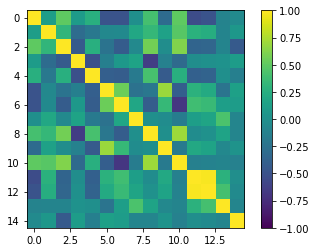

           A1        A2        A3        A4        A5        A6        A7  \
A1   1.000000  0.111138  0.503513  0.101113  0.263444 -0.490425 -0.490759   
A2   0.111138  1.000000  0.313156 -0.294481 -0.200240 -0.066462 -0.052264   
A3   0.503513  0.313156  1.000000 -0.433984  0.261230 -0.236587 -0.416351   
A4   0.101113 -0.294481 -0.433984  1.000000 -0.509087 -0.138862  0.065010   
A5   0.263444 -0.200240  0.261230 -0.509087  1.000000 -0.395075 -0.410590   
A6  -0.490425 -0.066462 -0.236587 -0.138862 -0.395075  1.000000  0.552237   
A7  -0.490759 -0.052264 -0.416351  0.065010 -0.410590  0.552237  1.000000   
A8  -0.003515  0.198428 -0.059642  0.161991 -0.184332 -0.243883  0.181881   
A9   0.413649  0.329613  0.576679 -0.637457  0.418899 -0.208679 -0.410186   
A10 -0.297254  0.143010 -0.019936 -0.119742 -0.423461  0.702990  0.338238   
A11  0.506585  0.482197  0.617885 -0.309771  0.259904 -0.403338 -0.680680   
A12 -0.531760  0.274927 -0.357213 -0.020486 -0.388205  0.286835  0.386767   

In [29]:
corr_matrix=X_death.corr();
plt.imshow(corr_matrix,interpolation='none',clim=(-1, 1));
plt.colorbar();
plt.show();

print(corr_matrix)

**4)** Remove strongly correlated values using *drop()*.

In [30]:
X_death_reg = X_death.drop("A13", axis=1);

**5)** Standardise the input and output values using the method *skl.preprocessing.scale()*

**6)** Instantiate the class *skl.linear_model.LinearRegression()* and use the *fit()* method to train the model.

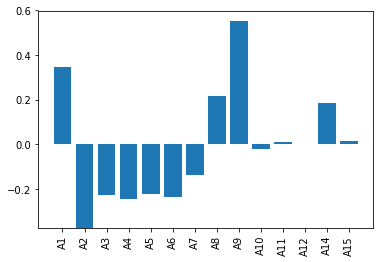

coefficient     value   p-value  t-statistic
    beta 1  0.345976  0.016835     2.482701
    beta 2 -0.375747  0.006761    -2.839414
    beta 3 -0.226633  0.112567    -1.618393
    beta 4 -0.243584  0.189600    -1.331900
    beta 5 -0.224218  0.112527    -1.618577
    beta 6 -0.236228  0.121719    -1.577352
    beta 7 -0.138678  0.265861    -1.126654
    beta 8  0.218477  0.032760     2.202957
    beta 9  0.552134  0.005307     2.930037
   beta 10 -0.020607  0.858706    -0.179045
   beta 11  0.011757  0.947371     0.066378
   beta 12 -0.000300  0.998087    -0.002411
   beta 13  0.186953  0.057951     1.945719
   beta 14  0.015173  0.872370     0.161567


In [31]:
# Standardise the input and output values
X_death_std = skl.preprocessing.scale(X_death_reg);
y_death_std = skl.preprocessing.scale(y_death);

# Train the regression
std_reg = skl.linear_model.LinearRegression();
std_reg.fit(X_death_std,y_death_std);


# Get column names as list
column_names = list(X_death_reg.columns.values);
x_pos = range(2,len(column_names)+2)

# Print bars
plt.bar(x_pos,std_reg.coef_, align='center');
plt.xticks(x_pos,column_names,rotation='vertical');
plt.show();

# Print significance test
significance_reg(std_reg,X_death_std,y_death_std);

**7)** Split *X* and *y* into a training and test set. Use [:-test_size], [-test_size:] to select all the variables but the last *test_size* rows and the last *test_size* rows respectively. Then fit the regression on the training data.

In [36]:
test_size = 20;

# Split the data into training/testing sets
X_death_reg_train = X_death_reg.values[:-test_size];
X_death_reg_test = X_death_reg.values[-test_size:];

# Split the targets into training/testing sets
y_death_train = y_death.values[:-test_size];
y_death_test = y_death.values[-test_size:];

# Create linear regression object
reg_death = sk_lm.LinearRegression()

# Train the model using the training sets
reg_death.fit(X_death_reg_train, y_death_train);

**8)** We print the learned regression coefficients.

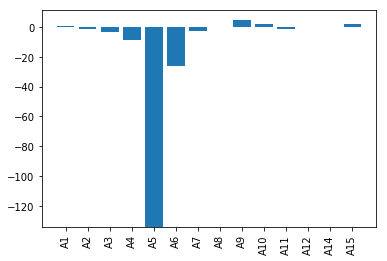

Mean squared error:  [ 2317.887492]


In [37]:
# Get column names as list
column_names = list(X_death_reg.columns.values);
x_pos = range(2,len(column_names)+2)

# Print bars
plt.bar(x_pos,reg_death.coef_, align='center');
plt.xticks(x_pos,column_names,rotation='vertical');
plt.show();

# The mean squared error
print("Mean squared error: ", mse(reg_death,X_death_reg_test,y_death_test));

**9)** We use forward selection to reduce the input matrix *x* by removing columns to prevent overfitting. 
Use the *forward_selection()* function defined above to get the indices of columns we keep.

In [38]:
#We do forward selection of the dataframe values
death_idcs = forward_selection(X_death_reg_train,y_death_train);


Mean squared error full model: [ 790.31692822] 

Starting foward selection...
best indices at iteration  1 : [0]
best indices at iteration  2 : [0, 1]
best indices at iteration  3 : [0, 1, 3]
best indices at iteration  4 : [0, 1, 3, 2]
best indices at iteration  5 : [0, 1, 3, 2, 5]
best indices at iteration  6 : [0, 1, 3, 2, 5, 4]
best indices at iteration  7 : [0, 1, 3, 2, 5, 4, 7]
best indices at iteration  8 : [0, 1, 3, 2, 5, 4, 7, 8]
best indices at iteration  9 : [0, 1, 3, 2, 5, 4, 7, 8, 6]
best indices at iteration  10 : [0, 1, 3, 2, 5, 4, 7, 8, 6, 9]
best indices at iteration  11 : [0, 1, 3, 2, 5, 4, 7, 8, 6, 9, 10]
best indices at iteration  12 : [0, 1, 3, 2, 5, 4, 7, 8, 6, 9, 10, 12]
best indices at iteration  13 : [0, 1, 3, 2, 5, 4, 7, 8, 6, 9, 10, 12, 13]
best indices at iteration  14 : [0, 1, 3, 2, 5, 4, 7, 8, 6, 9, 10, 12, 13, 11]
...done.

Mallow's CPs of best indices: [120.15253257255321, 119.99738601755971, 108.18772629223787, 107.45122392294817, 82.30948534916601, 78.

**10)** Learn a new regression using the subset of *X* found by forward selection.

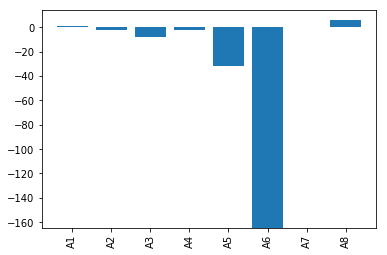

(Mean squared error before forward selection:  [ 2317.887492] )
Mean squared error after forward selection:  [ 1115.0269002]


In [39]:
# Create linear regression object
reg_death_fs = sk_lm.LinearRegression()

X_death_subset = X_death_reg_train[:,death_idcs];

# Train the model using the selected subset of the training sets
reg_death_fs.fit(X_death_subset, y_death_train);

# Get column names as list, get selected indices
column_names_fs = list(X_death_reg.columns.values[death_idcs]);
x_pos = range(1,len(column_names_fs)+1)

# Print bars
plt.bar(x_pos,reg_death_fs.coef_, align='center');
plt.xticks(x_pos,column_names,rotation='vertical');
plt.show();

# The mean squared error
print("(Mean squared error before forward selection: ", mse(reg_death,X_death_reg_test,y_death_test),")");
print("Mean squared error after forward selection: ", mse(reg_death_fs,X_death_reg_test[:,death_idcs],y_death_test));